# Проект для оператора связи

### Описание проекта
В данном проекте необходимо реализовать модель, способную прогнозировать отток клиентов. Пользователям, которые планируют уйти, будут предложены персональные скидки и промокоды. 

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

Таблица `contract_new.csv` содержит информацию о договоре;

Описание полей данных:
- `BeginDate` – дата начала пользования услугами
- `EndDate` – дата окончания пользования услугами
- `Type` – тип договора: ежемесячный, годовой и т.д.
- `PaperlessBilling` – выставления счёта по электронной почте
- `PaymentMethod` – способ оплаты
- `MonthlyCharges` – ежемесячные траты на услуги
- `TotalCharges` – всего потрачено денег на услуги


Таблица `personal_new.csv` содержит персональные данные клиента;

Описание полей данных:
- `gender` – пол
- `SeniorCitizen` – пенсионный статус по возрасту
- `Partner` – наличие супруга/супруги
- `Dependents` – наличие иждивенцев


Таблица `internet_new.csv` содержит информацию об интернет-услугах;

Описание полей данных:
- `InternetService` – наличие услуг Интернет
- `OnlineSecurity` – межсетевой экран
- `OnlineBackup` – облачное хранилище резервного копирования данных
- `DeviceProtection` – антивирус
- `TechSupport` – выделенная линия поддержки
- `StreamingTV` – онлайн-ТВ
- `StreamingMovies` – онлайн-кинотеатр


Таблица `phone_new.csv` содержит информацию об услугах телефонии.

Описание полей данных:
- `MultipleLines` – возможность подключения телефонного аппарата к нескольким линиям одновременно

- `customerID` содержит код клиента.

In [1]:
!pip install phik

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import warnings


from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
from catboost import CatBoostClassifier

RANDOM_STATE = 190623
warnings.filterwarnings("ignore")

In [3]:
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    contract = pd.read_csv(r'C:\Users\Acer\Documents\Практикум\Graduation project\contract_new.csv')
    internet = pd.read_csv(r'C:\Users\Acer\Documents\Практикум\Graduation project\internet_new.csv')
    personal = pd.read_csv(r'C:\Users\Acer\Documents\Практикум\Graduation project\personal_new.csv')
    phone = pd.read_csv(r'C:\Users\Acer\Documents\Практикум\Graduation project\phone_new.csv')    

## Первичный анализ данных

В данном разделе мы посмотрим на данные, поверхностно изучим их и сделаем первые выводы. После этого составим план работы. 

Более подробный анализ данных будет произведён в следующем разделе.

In [4]:
def describe_data(data):
    display(data.head(10))
    display(data.info())
    display(data.describe(include='all'))

In [5]:
describe_data(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


**Первые выводы о таблице contract**:
- Таблица импортируется корректно
- В таблице представлено 7043 объекта и 8 колонок с признаками
- В данных отсутствуют явные пропуски
- Необходимо поработать с типом данных, определить категориальные и числовые признаки. На первый взгляд:
1. Категориальные: Type, PaperlessBilling, PaymentMethod 
2. Числовые: MonthlyCharges, TotalCharges
3. Целевой признак: EndDate, содержит даты(клиент ушёл) и значения No(клиент продолжает пользоваться услугами). В дальнейшем будет преобразован.
4. Признаки для последующего удаления: customerID(после объединения таблиц будет удалён, т.к. не несёт полезной информации для обучения модели), BeginDate(будет преобразован в числовой признак с длительностью пользования услугами ушедших клиентов)
- В описании данных есть несколько интересных моментов:
1. Большинство клиентов продолжают пользоваться услугами оператора
2. Большинство клиентов оплачивают тариф электронно и ежемесячно, так же получают электронный чек 
3. В столбце TotalCharges можно заметить пустое часто встречающееся значение, этот момент я уже проанализировала и в данных присутствуют неявные пропуски, заполненные пробелом. В следующем разделе изучим более подробно.
- Необходимо привести названия столбцов к общепринятому виду.

In [6]:
describe_data(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


**Первые выводы о таблице internet**:
- Таблица импортируется корректно
- В таблице представлено 5517 объектов и 8 колонок с признаками
- В данных отсутствуют пропуски, об это говорит описание данных, точнее количество уникальных значений для каждой колонки.
- Все данные в таблице бинарные, но я оставлю их категориальными.
- На первый взгляд можно сказать о том, что большая часть клиентов не пользуется доп.услугами, т.к. топовое значение: No. А так же у большей части клиентов оптиковолоконный кабель. Более подробно изучим в следующем разделе и построим гистограммы.
- Необходимо привести названия столбцов к общепринятому виду.

In [7]:
describe_data(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


**Первые выводы о таблице personal:**
- Таблица импортируется корректно.
- В таблице представлено 7043 объекта и 5 колонок с признаками.
- В данной таблице все значения категориальные, столбец SeniorCitizen так же будет преобразован в категориальный признак.
- Большинство клиентов молодые мужчины без партнёра и без иждивенцев, хотя значения пола и наличия партнёра практически равны. Пенсионеров только 16 процентов.
-Необходимо привести названия столбцов к общепринятому виду.

In [8]:
describe_data(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


**Первые выводы о таблице phone:**
- Таблица импортируется корректно
- В таблице 6361 объект и 2 колонки с признаками
- Отсутствуют пропущенные значения
- Большинство людей всё-таки не имеют возможности ведения параллельных линий во время звонка, хотя значения близки
- Необходимо привести названия столбцов к общепринятому виду.

## План работы

1. Предобработка данных:
 1. Приведение названий столбцов к общепринятому виду
 2. Изменение типов данных
 3. Проверка таблиц на наличие неявных пропусков и явных/неявных дубликатов
 4. Объединение таблиц по столбцу customerID, необходимо проследить, чтобы все пользователи попали в датасет
 5. Работа с появившимися пропусками.
2. Анализ данных:
 1. Создание целевого признака из EndDate
 1. Построение графиков для изучения зависимостей между признаками и целевым признаком
 2. Построение гистограмм для изучения категориальных признаков.
 3. Составление портретов клиентов, которые остались и которые ушли из компании в виде круговой диаграммы.
 4. Изучение выбросов 
 5. Изучение баланса классов
 6. Создание новых признаков: Количество дней, в течение которых клиенты пользовались услугами компании(для ушедших пользователей), возможно в процессе добавлятся ещё признаки.
 7. Проверка корреляции с целевым признаком и проверка на мультиколлинеарность.
3. Построение моделей:
 1. Разбиение данных на train и test, со стратификацией и перемешиванием.
 2. Составление pipeline для моделей:
  1. Для Random Forest: Ordinal Encoder + масштабирование + GridSearchCV
  2. Для Catboost: GridSearchCV
 3. Выбор лучшей модели (по метрике на кроссвалидации model.best_score_)
 4. Проверка на тестовой выборке лучшей модели
 5. Построение графика ROC
 6. Анализ важности признаков выбранной модели(model.features_importances_)
 7. Построение матрицы ошибок
 8. Анализ второй метрики accuracy
4. Создание отчёта:
 1. Был ли выполнен план, какие шаги пришлось изменить и почему.
 2. Описание ключевых шагов решения задачи.
 3. Описание предобработки данных
 4. Сравнение значений метрики на кросс-валидации для всех моделей в сводной таблице.
 5. Описание выбранной модели машинного обучения: архитектура, сетка гиперпараметров, лучшие гиперпараметры

## Предобработка данных 

Явные дубликаты в датасетах отсутствуют, о чём говорит частота появления равная 1 в customerID, т.е. все ID уникальны.

Проверим таблицы на наличие неявных пропусков. В столбце TotalCharges при первичном анализе данных были замечены пустые часто встречающееся значение, можно предположить, что это пробелы. Изучим природу их возникновения.

In [9]:
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Можно заметить, что все строки, в которых встречается пробел имеют общую особенность: это клиенты которые подключили услуги в дату выгрузки датасета 2020-02-01. Проверим, встречается ли похожая ситуация для строк с этой датой.

In [10]:
contract[contract['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [11]:
contract[contract['TotalCharges'] == ' '] == contract[contract['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,True,True,True,True,True,True,True,True
753,True,True,True,True,True,True,True,True
936,True,True,True,True,True,True,True,True
1082,True,True,True,True,True,True,True,True
1340,True,True,True,True,True,True,True,True
3331,True,True,True,True,True,True,True,True
3826,True,True,True,True,True,True,True,True
4380,True,True,True,True,True,True,True,True
5218,True,True,True,True,True,True,True,True
6670,True,True,True,True,True,True,True,True


Выборки совпадают. Так же можно заметить, что у всех пользователей тип оплаты на два года, посмотрим другие данные с таким же типом оплаты.

In [12]:
contract[(contract['Type'] == 'Two year') & (contract['BeginDate'] != '2020-02-01')].sort_values('BeginDate', ascending=False)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5987,1099-GODLO,2020-01-01,No,Two year,No,Mailed check,20.35,20.76
2828,8559-WNQZS,2020-01-01,No,Two year,No,Mailed check,20.45,20.45
3412,4854-SSLTN,2019-12-01,No,Two year,No,Mailed check,59.50,121.38
3193,1407-DIGZV,2019-11-01,No,Two year,No,Mailed check,19.10,59.59
6818,2710-WYVXG,2019-11-01,No,Two year,No,Mailed check,71.10,213.3
...,...,...,...,...,...,...,...,...
6290,2530-ENDWQ,2013-12-01,No,Two year,Yes,Bank transfer (automatic),93.70,6933.8
3040,7317-GGVPB,2013-11-01,No,Two year,Yes,Credit card (automatic),108.60,8145.0
975,2834-JRTUA,2013-11-01,No,Two year,Yes,Electronic check,108.05,8184.79
3439,0917-EZOLA,2013-10-01,No,Two year,Yes,Bank transfer (automatic),104.15,7915.4


Клиенты с таким типом тарифа платят в конце месяца, в этом можно убедить если посмотреть на клиентов, которые подключили услуги 20-01-01, у них внесён платёж только за один месяц. Следовательно заполним пропуски в данных 0.

In [13]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = 0

In [14]:
#Проверка замены
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


Создадим целевой признак из признака EndDate, где 0 - пользователь остался, 1 - пользователь ушёл

In [15]:
contract['Churn'] = np.where(contract['EndDate'] == 'No', '0', '1').astype(int)

In [16]:
contract.head(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1


In [17]:
#Проверка замены
len(contract['Churn'] == 1) == len(~(contract['EndDate'] == 'No'))

True

Для создания нового признака, который будет показывать какое количество дней клиент пользуется услугами, изменим столбцы `BeginDate` и `EndDate` и приведём их к формату даты. Значения No заменим на дату выгрузки из базы данных.

In [18]:
contract['EndDate'] = contract['EndDate'].replace('No', '2020-02-01')

In [19]:
#Проверка замены
(contract['EndDate'] == 'No').sum()

0

In [20]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   Churn             7043 non-null   int32         
dtypes: datetime64[ns](2), float64(1), int32(1), object(5)
memory usage: 467.8+ KB


Так же переведём тип данных признака `TotalCharges` в float.

In [21]:
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(4)
memory usage: 467.8+ KB


In [22]:
contract['duration'] = (contract['EndDate'] - contract['BeginDate']).dt.days

contract['duration']

0         31
1       1036
2        123
3       1371
4        153
        ... 
7038     730
7039    2191
7040     337
7041     215
7042    2010
Name: duration, Length: 7043, dtype: int64

Теперь можно объединить таблицы. Будем делать это с помощью merge по признаку customerID.

In [23]:
data = contract.merge(personal, how='outer', on='customerID')
data = data.merge(internet, how='outer', on='customerID')
data = data.merge(phone, how='outer', on='customerID')

In [24]:
pd.set_option('display.max_columns', None)

In [25]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,duration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int32         
 9   duration          7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

In [27]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,duration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Переименуем столбцы датафрейма.

In [28]:
data.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn', 'duration', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']

In [29]:
data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn',
       'duration', 'gender', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines'],
      dtype='object')

В новом датафрейме появились пропуски, изучим их.

In [30]:
data.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn                   0
duration                0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [31]:
data.query('internet_service.isna()')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
11,7469-LKBCI,2018-10-01,2020-02-01,Two year,No,Credit card (automatic),18.95,312.30,0,488,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
16,8191-XWSZG,2015-10-01,2020-02-01,One year,No,Mailed check,20.65,1106.01,0,1584,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
21,1680-VDCWW,2019-02-01,2020-02-01,One year,No,Bank transfer (automatic),19.80,237.60,0,365,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
22,1066-JKSGK,2019-11-01,2020-02-01,Month-to-month,No,Mailed check,20.15,61.05,0,92,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
33,7310-EGVHZ,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),20.20,22.22,0,31,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7017,4807-IZYOZ,2015-11-01,2020-02-01,Two year,No,Bank transfer (automatic),20.65,1053.15,0,1553,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7019,9710-NJERN,2016-11-01,2020-02-01,Two year,No,Mailed check,20.15,785.85,0,1187,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7020,9837-FWLCH,2019-02-01,2020-02-01,Month-to-month,Yes,Electronic check,19.20,246.53,0,365,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7030,0871-OPBXW,2019-12-01,2020-02-01,Month-to-month,Yes,Mailed check,20.05,40.10,0,62,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


Пропуски во всех столбцах из датафрейма internet соответствуют одним и тем же людям. Вероятнее всего пропуски в столбцах появились из-за того, что у клиентов услуги не подключены, заполним их значением No. Такая же ситуация со столбцом multiple_lines.

In [32]:
for column in ['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines']:
    data[column] = data[column].fillna('No')

In [33]:
data.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
duration             0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

Так же переведём все булевы переменные из object в int, для более удобного анализа

In [34]:
data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn',
       'duration', 'gender', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines'],
      dtype='object')

In [35]:
def bool_to_int(data, column):
    data[column] = np.where(data[column] == 'No', '0', '1').astype(int)

In [36]:
for column in ['paperless_billing', 'partner', 'dependents', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines']:
    bool_to_int(data, column)

In [37]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,31.04,0,31,Female,0,1,0,DSL,0,1,0,0,0,0,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,2071.84,0,1036,Male,0,0,0,DSL,1,0,1,0,0,0,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,1,Mailed check,53.85,226.17,0,123,Male,0,0,0,DSL,1,1,0,0,0,0,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,0,0,DSL,1,0,1,1,0,0,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,1,Electronic check,70.70,353.50,0,153,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0


## Анализ данных

In [38]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
paperless_billing,7043.0,0.592219,0.491457,0.00,0.00,1.00,1.00,1.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2115.312885,2112.742814,0.00,436.75,1343.35,3236.69,9221.38
churn,7043.0,0.156325,0.363189,0.00,0.00,0.00,0.00,1.00
duration,7043.0,898.555729,683.130510,0.00,276.00,761.00,1461.00,2314.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.00,0.00,0.00,1.00
partner,7043.0,0.483033,0.499748,0.00,0.00,0.00,1.00,1.00
dependents,7043.0,0.299588,0.458110,0.00,0.00,0.00,1.00,1.00
online_security,7043.0,0.286668,0.452237,0.00,0.00,0.00,1.00,1.00
online_backup,7043.0,0.344881,0.475363,0.00,0.00,0.00,1.00,1.00


Доля пользователей:
1. С пенсионным удостоверением - 16%
2. Имеют партнёра - 48%
3. Имеют иждивенцев - 29,9%

Доля пользователей услуг:
1. Электронный чек - 59%
2. Антивирус (DeviceProtection) - 34,3%
3. Блокировка небезопасных сайтов (OnlineSecurity) - 28,6%
4. Выделенная линия технической поддержки (TechSupport) - 29%
5. Облачное хранилище файлов для резервного копирования данных (OnlineBackup) - 34,4%
6. Стриминговое телевидение (StreamingTV) - 38.4%
7. Каталог фильмов (StreamingMovies) - 38.7%
8. Возможность подключения телефонного аппарата к нескольким линиям одновременно - 42%

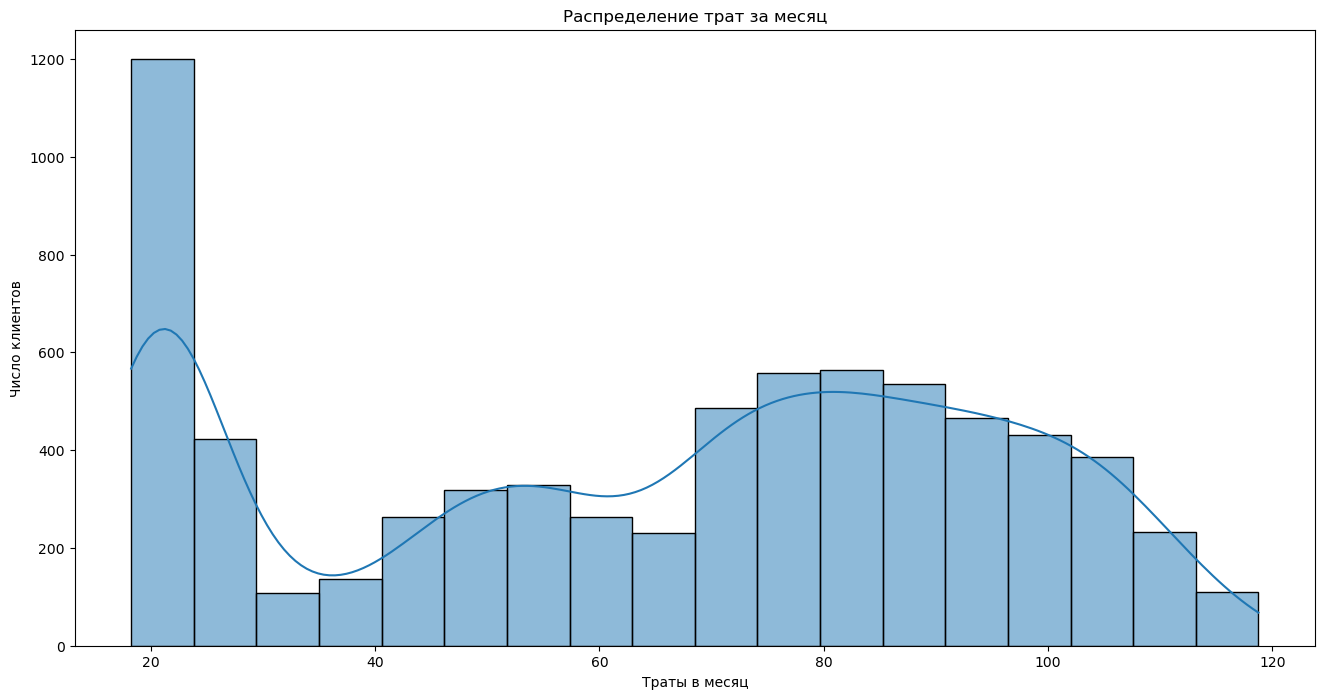

In [39]:
plt.figure(figsize=(16, 8))

sns.histplot(data['monthly_charges'], kde=True)
plt.title('Распределение трат за месяц')
plt.xlabel('Траты в месяц')
plt.ylabel('Число клиентов');

Из графика можно заметить, что клиенты делятся условно на три группы:
1. Платят 20-30 долларов за тариф
2. Платят 30-70 долларов за тариф
3. Платят 70-120 долларов за тариф.

Используем эти данные в качестве дополнительного признака.

In [40]:
data['customer_groups'] = 'medium'
data.loc[data['monthly_charges'] <= 30, 'customer_groups'] = 'low'
data.loc[data['monthly_charges'] > 70, 'customer_groups'] = 'high'

In [41]:
data.loc[(data['monthly_charges'] > 30) & (data['monthly_charges'] <= 70)]['customer_groups'].unique()

array(['medium'], dtype=object)

In [42]:
data.loc[data['monthly_charges'] <= 30]['customer_groups'].unique()

array(['low'], dtype=object)

In [43]:
data.loc[data['monthly_charges'] > 70]['customer_groups'].unique()

array(['high'], dtype=object)

In [44]:
data['customer_groups'].value_counts()

high      3583
medium    1807
low       1653
Name: customer_groups, dtype: int64

Можно заметить, что несмотря на выборос в районе 20 у.е., пользователей из самой высокой тарифной группы больше практически в два раза. Изучим более подробно каждую группу.

In [45]:
data['customer_groups'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [46]:
for val in data['customer_groups'].unique():
    print(f'Описание данных для группы {val}')
    display(data[data['customer_groups'] == val].describe().T)

Описание данных для группы low


,count,mean,std,min,25%,50%,75%,max
paperless_billing,1653.0,0.310345,0.462775,0.00,0.00,0.00,1.0,1.00
monthly_charges,1653.0,21.503539,2.623052,18.25,19.75,20.20,24.2,29.95
total_charges,1653.0,601.754555,523.416004,0.00,139.87,456.46,970.6,1999.62
churn,1653.0,0.101633,0.302257,0.00,0.00,0.00,0.0,1.00
duration,1653.0,818.935269,685.139214,0.00,184.00,638.00,1371.0,2191.00
senior_citizen,1653.0,0.045977,0.209499,0.00,0.00,0.00,0.0,1.00
partner,1653.0,0.469449,0.499217,0.00,0.00,0.00,1.0,1.00
dependents,1653.0,0.405929,0.491219,0.00,0.00,0.00,1.0,1.00
online_security,1653.0,0.007260,0.084919,0.00,0.00,0.00,0.0,1.00
online_backup,1653.0,0.009074,0.094855,0.00,0.00,0.00,0.0,1.00


Описание данных для группы medium


,count,mean,std,min,25%,50%,75%,max
paperless_billing,1807.0,0.562811,0.496176,0.00,0.000,1.00,1.000,1.00
monthly_charges,1807.0,53.828971,10.234522,30.05,45.775,54.45,61.450,70.00
total_charges,1807.0,1408.127615,1275.188699,0.00,335.070,1021.76,2156.285,5151.63
churn,1807.0,0.111787,0.315192,0.00,0.000,0.00,0.000,1.00
duration,1807.0,757.511345,638.341276,0.00,184.000,580.00,1218.000,2191.00
senior_citizen,1807.0,0.112894,0.316551,0.00,0.000,0.00,0.000,1.00
partner,1807.0,0.419480,0.493611,0.00,0.000,0.00,1.000,1.00
dependents,1807.0,0.299391,0.458118,0.00,0.000,0.00,1.000,1.00
online_security,1807.0,0.410072,0.491983,0.00,0.000,0.00,1.000,1.00
online_backup,1807.0,0.368567,0.482550,0.00,0.000,0.00,1.000,1.00


Описание данных для группы high


,count,mean,std,min,25%,50%,75%,max
paperless_billing,3583.0,0.737092,0.440274,0.00,0.00,1.00,1.00,1.00
monthly_charges,3583.0,90.232291,12.297545,70.05,79.90,89.70,100.05,118.75
total_charges,3583.0,3170.237725,2325.184537,0.00,1124.25,2727.12,4929.92,9221.38
churn,3583.0,0.204019,0.403039,0.00,0.00,0.00,0.00,1.00
duration,3583.0,1006.420597,686.223594,0.00,396.00,914.00,1584.00,2314.00
senior_citizen,3583.0,0.240581,0.427496,0.00,0.00,0.00,0.00,1.00
partner,3583.0,0.521351,0.499614,0.00,0.00,1.00,1.00,1.00
dependents,3583.0,0.250628,0.433435,0.00,0.00,0.00,1.00,1.00
online_security,3583.0,0.353335,0.478072,0.00,0.00,0.00,1.00,1.00
online_backup,3583.0,0.487859,0.499922,0.00,0.00,0.00,1.00,1.00


Группа low:
1. *10%* клиентов из этой группы ушли.
2. Доля пенсионеров составляет всего 4 процента.
3. Менее 1% клиентов пользуются дополнительными услугами, возможностью подключения телефонного аппарата к нескольким линиям одновременно 20%
4. Продолжительность пользования услугами средняя из трёх групп (порядка 2,5 лет)
5. 31% клиентов получают электронный чек.

Группа medium:
1. *11%* клиентов из этой группы ушли.
2. От 25% до 41% клиентов пользуются дополнительными услугами, возможностью подключения телефонного аппарата к нескольким линиям одновременно 16%
3. Самая короткая продолжительность пользования услугами (порядка 2 лет)
4. Более половины клиентов получают электронный чек.

Группа high:
1. *20%* клиентов из этой группы ушли. Возможно здесь имеет место внешний фактор, т.к. в этой группе самый высокий процент пенсионеров: 24%, а так же неравномерность выборки.
2. В этой группе самые высокие показатели дополнительных услуг, от 35% до 62%, возможность подключения телефонного аппарата к нескольким линиям одновременно 64%
3. 73% пользователей получают электронный чек.
4. Самая высокая продолжительность пользования услугами. (Чуть менее 3 лет)

Можно сделать вывод, что группа с самой высокой платой за месяц пользуется бОльшим количеством услуг, дольше всего, но при этом процент ухода клиентов так же самый высокий. Возможно это связано с неравномерностью выборок.

Изучим признаки даты начала и конца использования услуг.

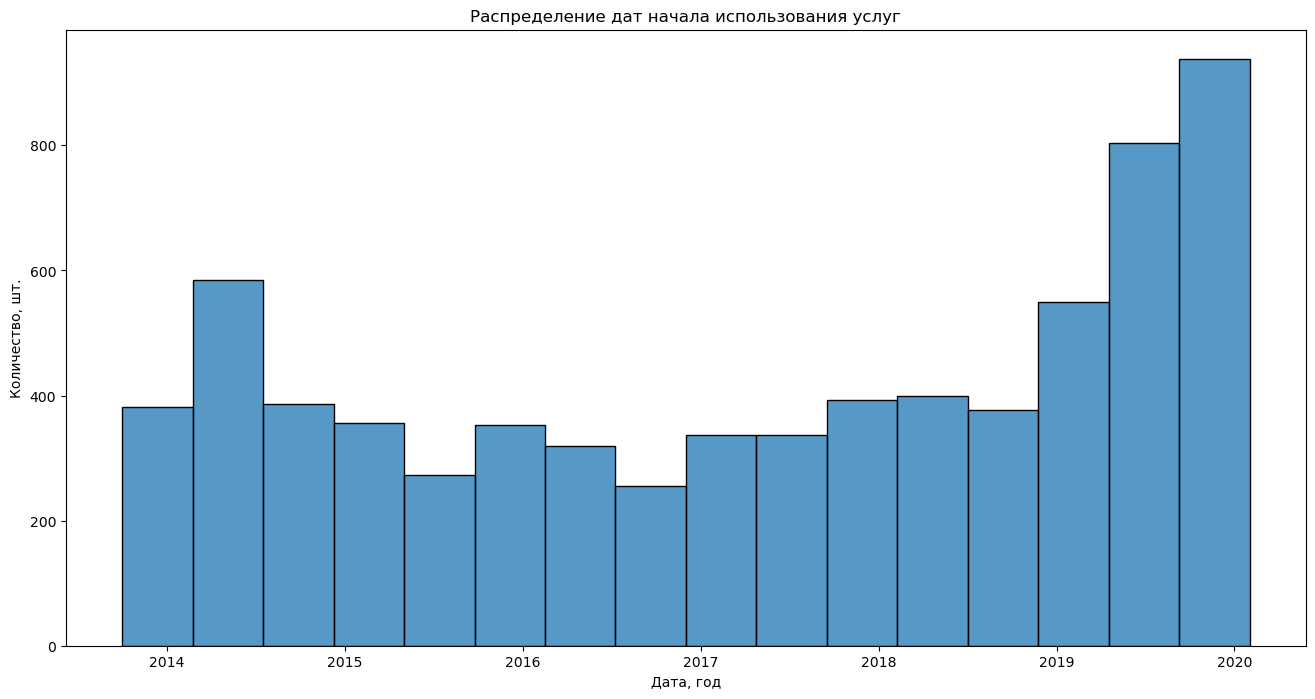

In [47]:
plt.figure(figsize=(16, 8))
sns.histplot(data['begin_date'])
plt.title('Распределение дат начала использования услуг')
plt.xlabel('Дата, год')
plt.ylabel('Количество, шт.');

На графике видно два пика, в середине 2014 года компания начала расти, в 2015 вышла на плато и активно развивается с 2019.

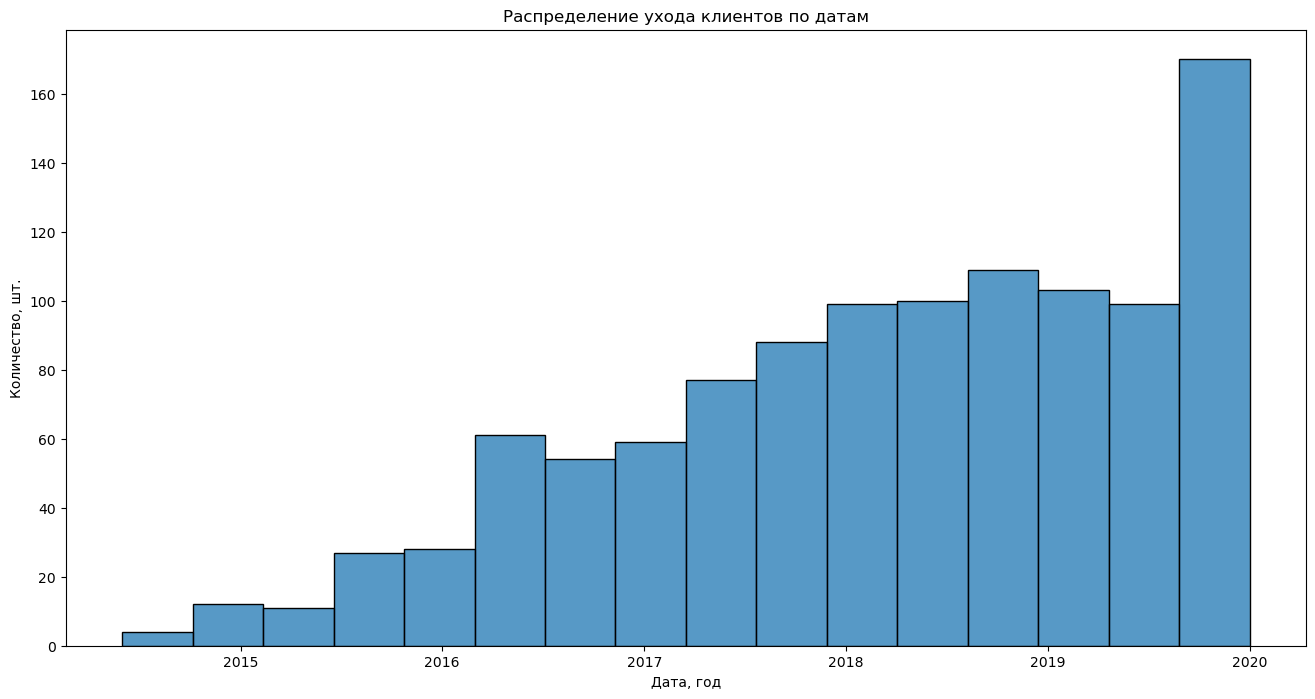

In [48]:
plt.figure(figsize=(16, 8))
sns.histplot(data[data['end_date'] != '2020-02-01']['end_date'])
plt.title('Распределение ухода клиентов по датам')
plt.xlabel('Дата, год')
plt.ylabel('Количество, шт.');

Количество уходящих клиентов постоянно росло и в конце 2019 года достигло своего пика.

Удалим стоблцы `customer_id`, `begin_date` и `end_date`, и разделим численные и категориальные переменные.

In [49]:
data = data.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

In [50]:
cat_features = data.select_dtypes(include='object').columns

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   int32  
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   churn              7043 non-null   int32  
 6   duration           7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   int32  
 10  dependents         7043 non-null   int32  
 11  internet_service   7043 non-null   object 
 12  online_security    7043 non-null   int32  
 13  online_backup      7043 non-null   int32  
 14  device_protection  7043 non-null   int32  
 15  tech_support       7043 non-null   int32  
 16  streaming_tv       7043 

In [52]:
stay = data['churn'] == 1
gone = data['churn'] == 0

In [53]:
num_features = data[['monthly_charges', 'total_charges', 'duration']].columns
num_features

Index(['monthly_charges', 'total_charges', 'duration'], dtype='object')

Вернём категориальные переменные к Yes/No

In [54]:
def int_to_object(data, column):
    data[column] = np.where(data[column] == 1, 'Yes', 'No')

In [55]:
for column in ['paperless_billing', 'partner', 'senior_citizen', 'dependents', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines']:
    int_to_object(data, column)

In [56]:
data.head(10)

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_groups
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No,low
1,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,medium
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,medium
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No,medium
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,high
5,Month-to-month,Yes,Electronic check,99.65,1150.96,0,337,Female,No,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,high
6,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0,671,Male,No,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,high
7,Month-to-month,No,Mailed check,29.75,300.48,0,306,Female,No,No,No,DSL,Yes,No,No,No,No,No,No,low
8,Month-to-month,Yes,Electronic check,104.80,3573.68,0,945,Female,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,high
9,One year,No,Bank transfer (automatic),56.15,1628.35,1,882,Male,No,No,Yes,DSL,Yes,Yes,No,No,No,No,No,medium


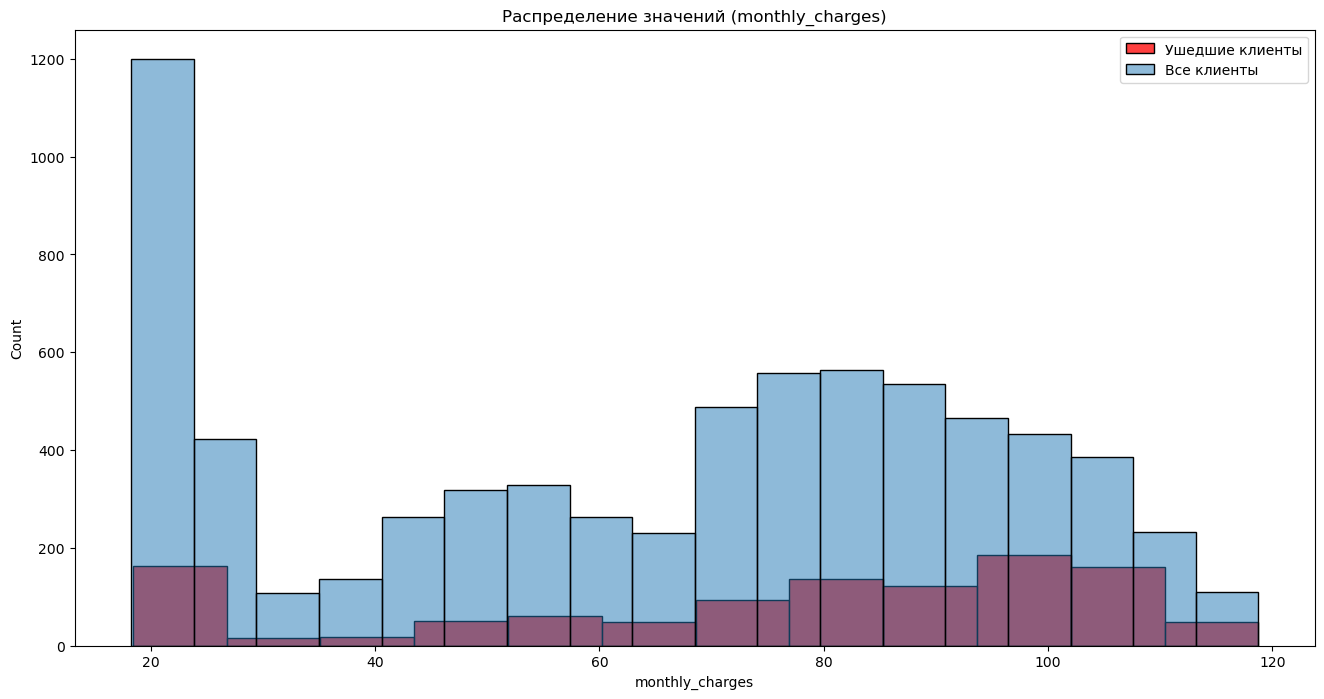

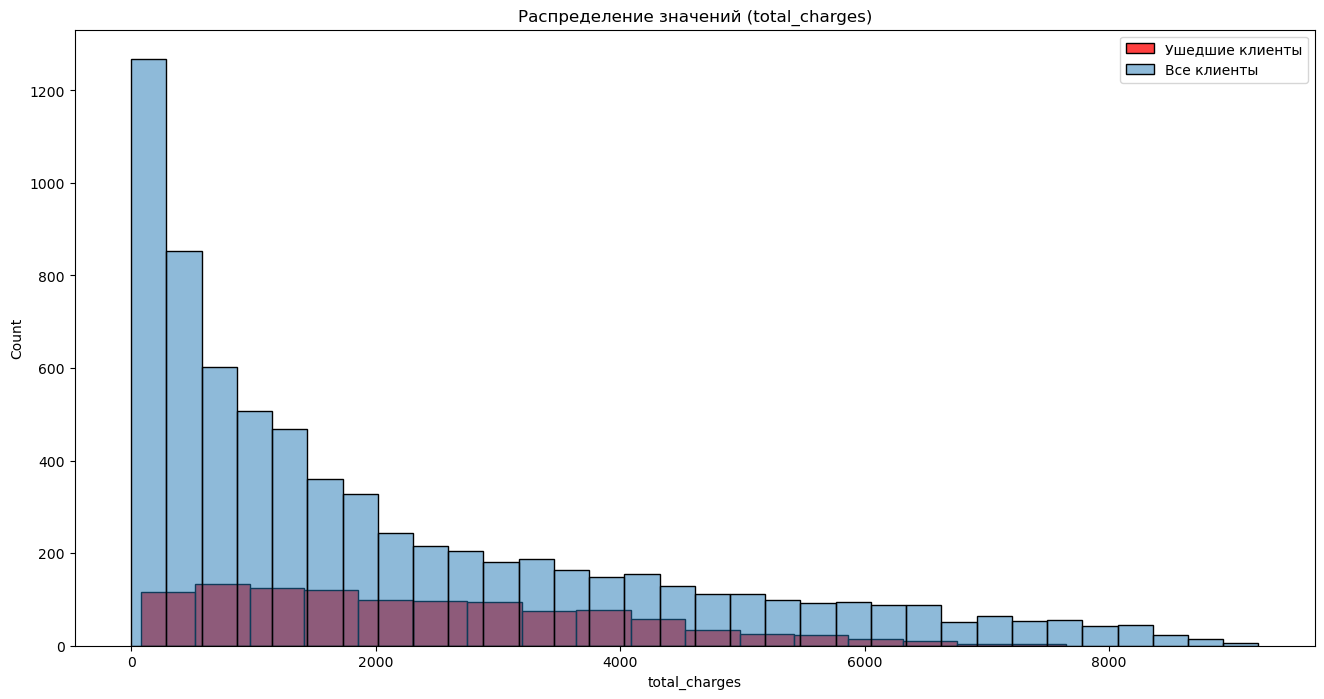

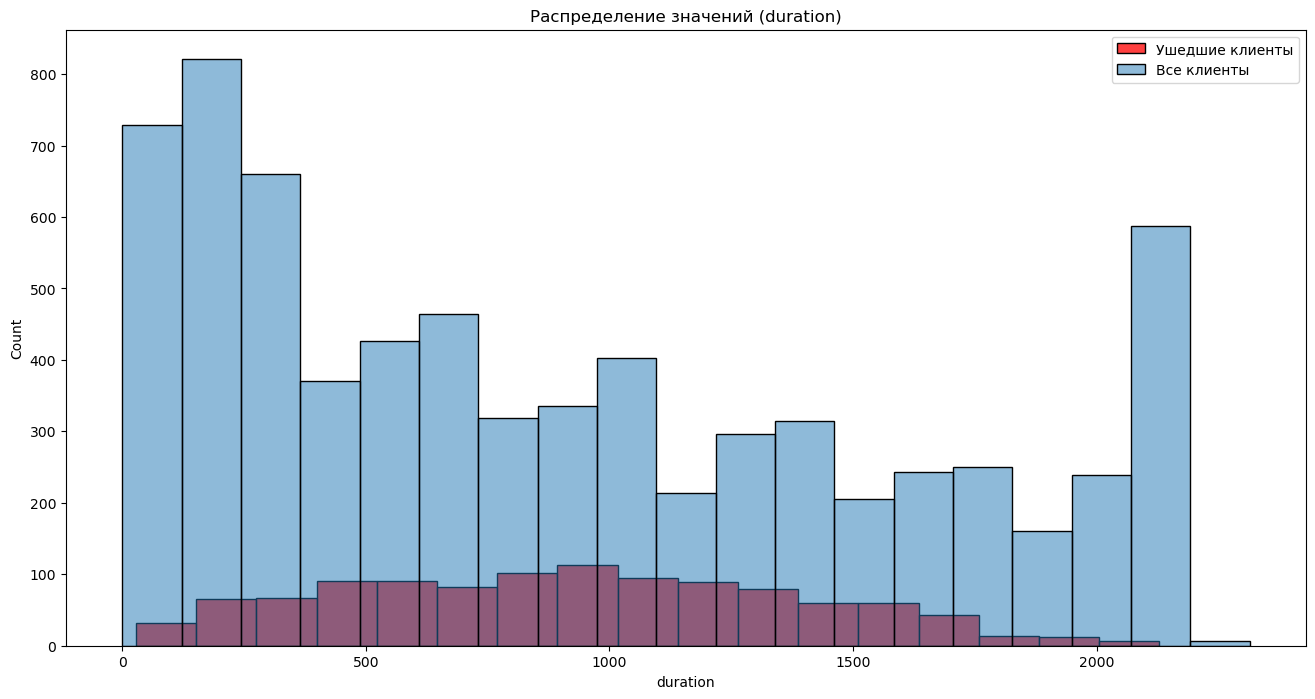

In [57]:
for col in num_features:
    plt.subplots(figsize=(16, 8))
    sns.histplot(data.loc[stay, col], color='r', label='Ушедшие клиенты')
    sns.histplot(data[col], alpha=0.5, label='Все клиенты')
    plt.legend()
    plt.title(f'Распределение значений ({col})');

Изучим какими услугами пользовались ушедшие и оставшиеся клиенты.

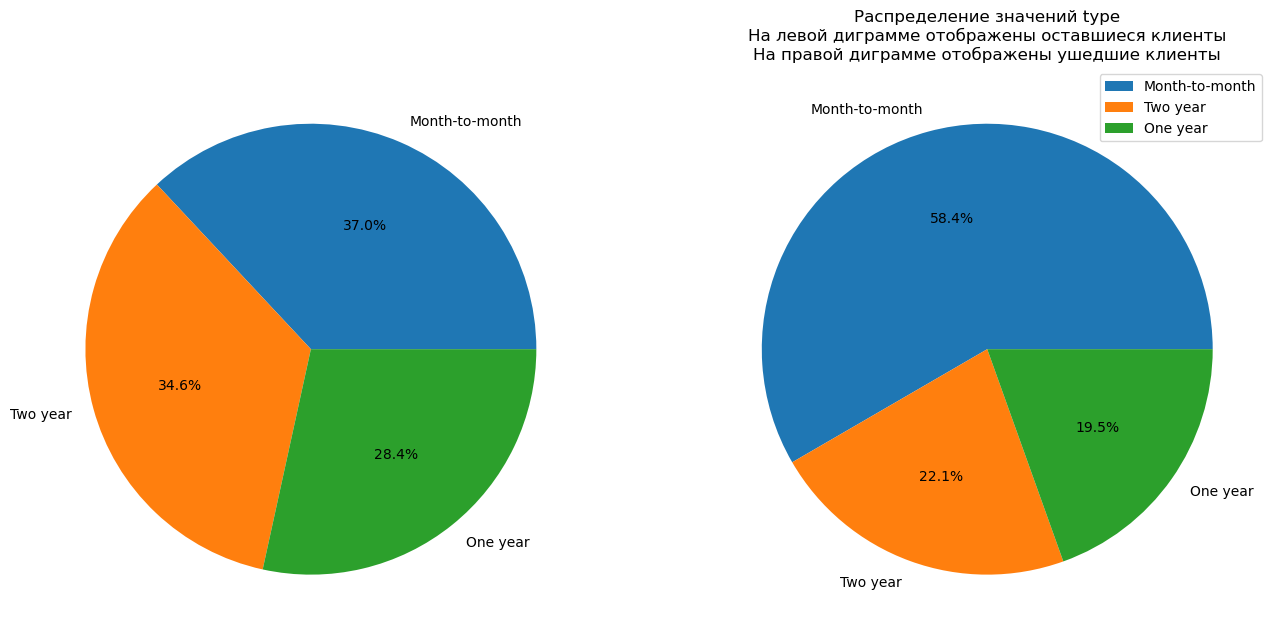

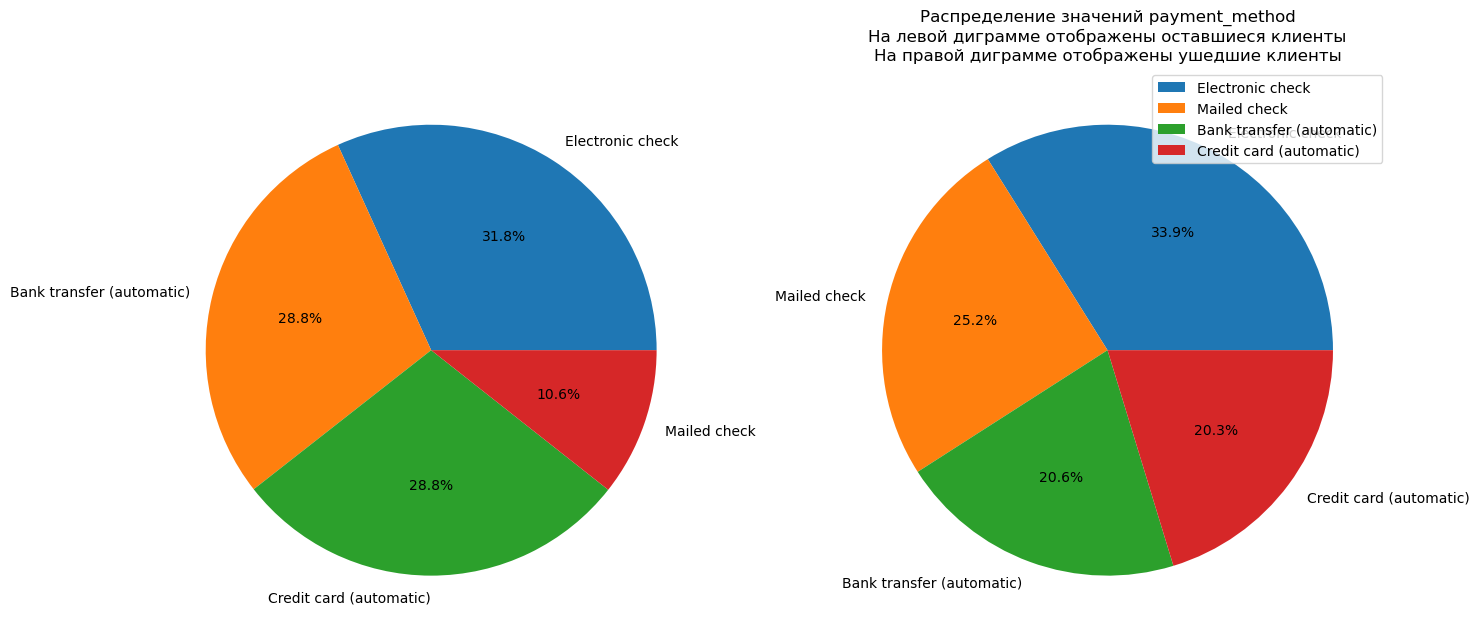

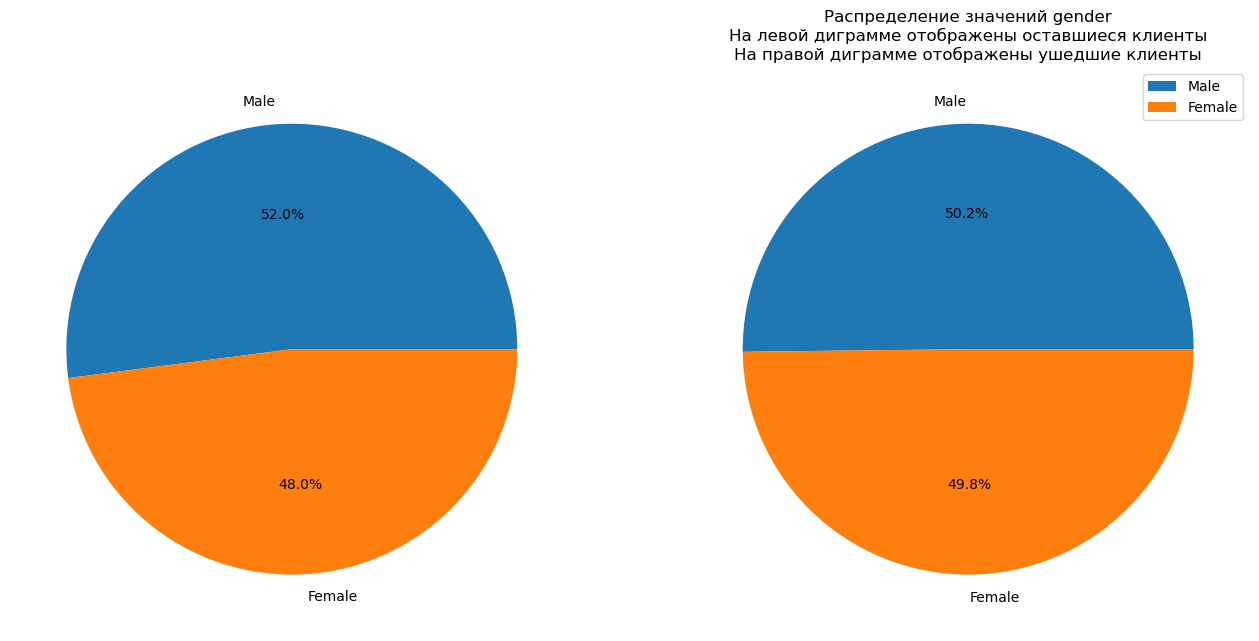

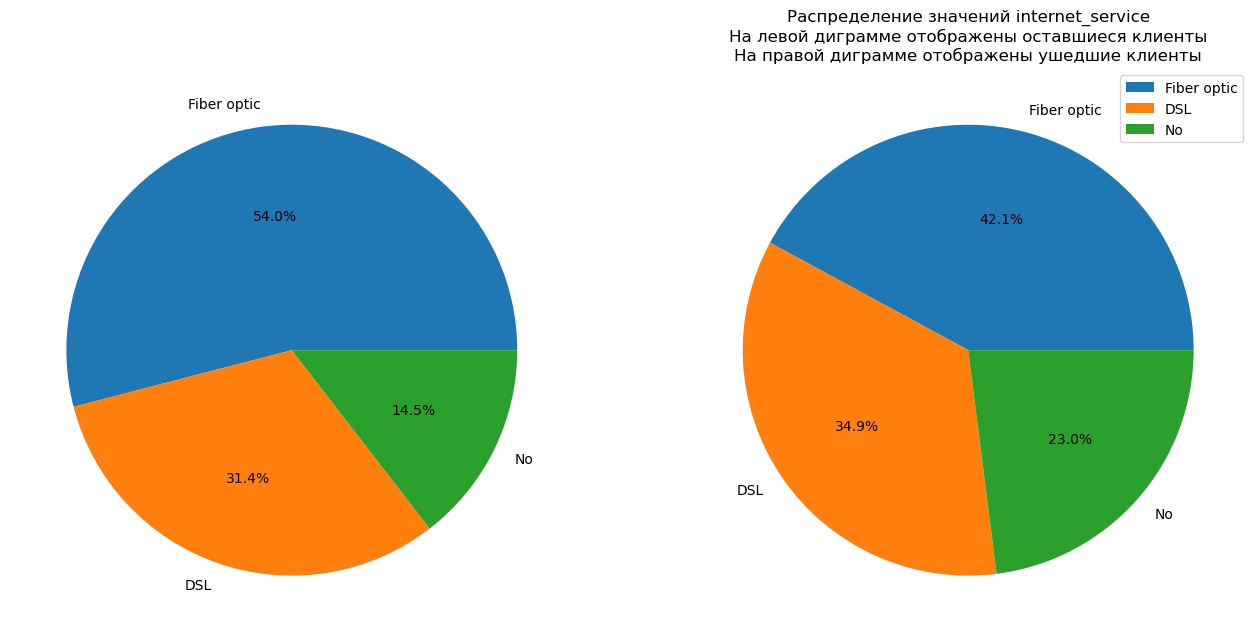

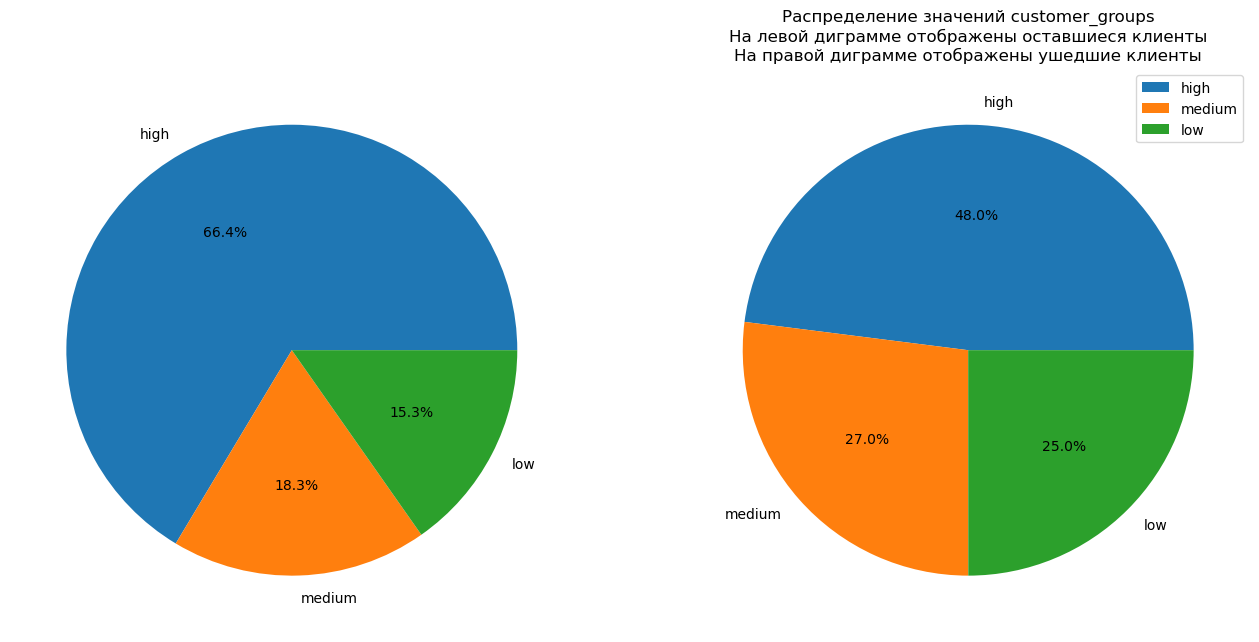

In [58]:
for col in cat_features:
    fig, axs = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
    axs[0].pie(data.loc[stay, col].value_counts(), labels=data.loc[stay, col].value_counts().index, autopct="%1.1f%%")
    axs[1].pie(data.loc[gone, col].value_counts(), labels=data.loc[gone, col].value_counts().index, autopct="%1.1f%%")
    plt.legend()
    plt.title(f'Распределение значений {col}\nНа левой диграмме отображены оставшиеся клиенты\nНа правой диграмме отображены ушедшие клиенты');

Проверим наши переменные на связь друг с другом, для этого используем phik.

In [59]:
phik = data.phik_matrix(interval_cols=num_features)
phik

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_groups
type,1.000000,0.106860,0.277462,0.388444,0.470860,0.094015,0.634155,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498,0.404362
paperless_billing,0.106860,1.000000,0.370495,0.467812,0.201703,0.083398,0.026799,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972,0.213341
payment_method,0.277462,0.370495,1.000000,0.399526,0.335666,0.214832,0.350964,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313,0.297220
monthly_charges,0.388444,0.467812,0.399526,1.000000,0.710905,0.226280,0.387727,0.008175,0.304985,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883,0.958881
total_charges,0.470860,0.201703,0.335666,0.710905,1.000000,0.302890,0.848337,0.000000,0.135650,0.381958,0.084247,0.490081,0.522090,0.622445,0.640977,0.550065,0.641488,0.643210,0.573191,0.556918
churn,0.094015,0.083398,0.214832,0.226280,0.302890,1.000000,0.374569,0.008581,0.086159,0.226688,0.046871,0.056621,0.132594,0.229482,0.218380,0.103652,0.200198,0.222232,0.261237,0.080210
duration,0.634155,0.026799,0.350964,0.387727,0.848337,0.374569,1.000000,0.000000,0.063315,0.453688,0.198729,0.060845,0.395693,0.414982,0.426931,0.404795,0.339313,0.339313,0.398222,0.202638
gender,0.000000,0.000000,0.000000,0.008175,0.000000,0.008581,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
senior_citizen,0.086231,0.242133,0.292725,0.304985,0.135650,0.086159,0.063315,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313,0.136284
partner,0.179736,0.013218,0.243008,0.203545,0.381958,0.226688,0.453688,0.000000,0.016992,1.000000,0.652122,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.220101,0.050533


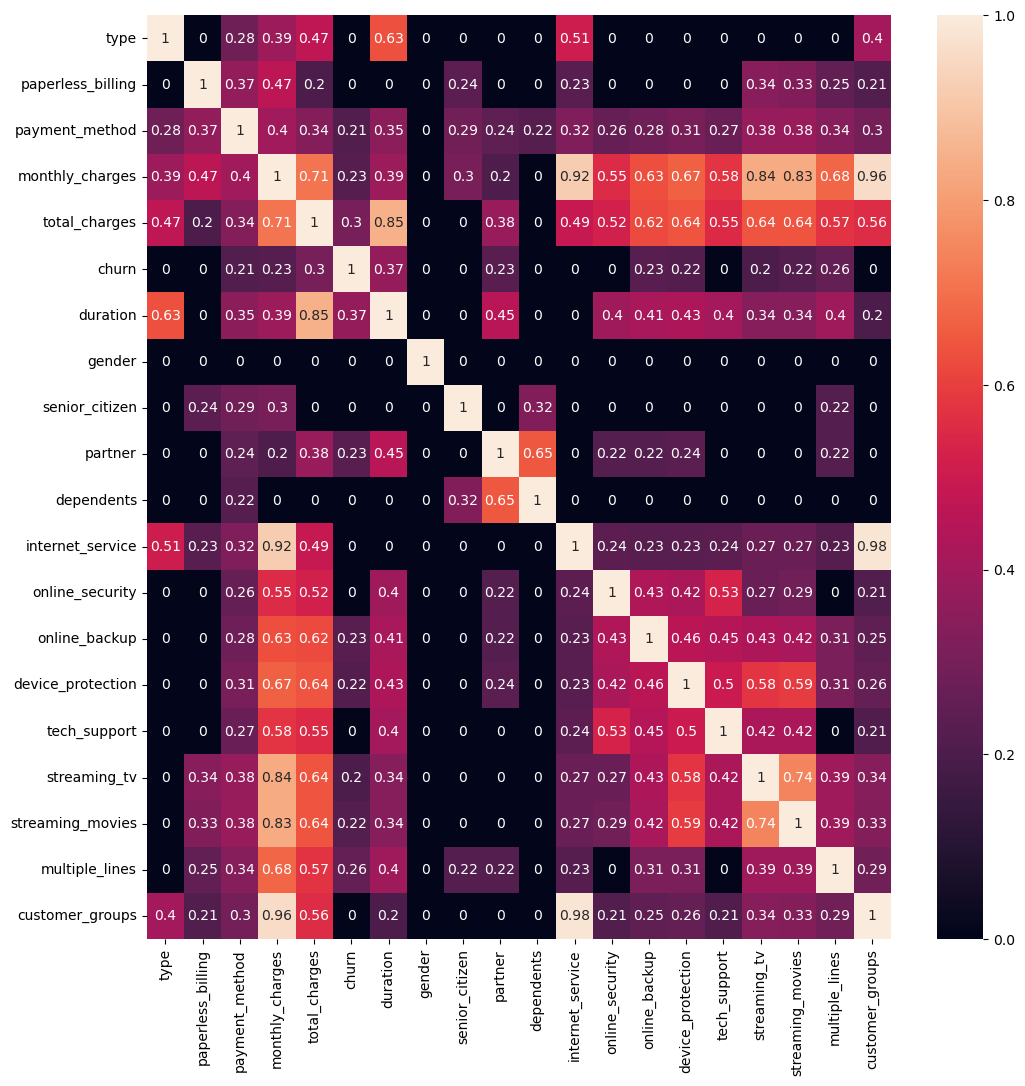

In [60]:
plt.figure(figsize=(12,12))
phik[np.abs(phik < 0.2)] = 0
sns.heatmap(phik, annot=True);

In [61]:
phik['churn'].sort_values(ascending=False)

churn                1.000000
duration             0.374569
total_charges        0.302890
multiple_lines       0.261237
online_backup        0.229482
partner              0.226688
monthly_charges      0.226280
streaming_movies     0.222232
device_protection    0.218380
payment_method       0.214832
streaming_tv         0.200198
type                 0.000000
tech_support         0.000000
dependents           0.000000
online_security      0.000000
internet_service     0.000000
paperless_billing    0.000000
senior_citizen       0.000000
gender               0.000000
customer_groups      0.000000
Name: churn, dtype: float64

Как и было обнаружено при анализе ранее, группа людей с высокими платежами за тариф и которая являлась клиентами дольше всего, уходит чаще. Матрица связей это подтвердила.

Проблема мультиколлинеарности может быть для столбцов `monthly_charges`, `internet_service` и `customer_groups`. Пока не будем ничего удалять, т.к. обучаться будут деревянные модели, а они не чувствительны к мультиколлинеарности.

**Выводы**

При изучении датасета были получены результаты:

- Доля пользователей:
1. С пенсионным удостоверением - 16%
2. Имеют партнёра - 48%
3. Имеют иждивенцев - 29,9%

- Доля пользователей услуг:
1. Электронный чек - 59%
2. Антивирус (DeviceProtection) - 34,3%
3. Блокировка небезопасных сайтов (OnlineSecurity) - 28,6%
4. Выделенная линия технической поддержки (TechSupport) - 29%
5. Облачное хранилище файлов для резервного копирования данных (OnlineBackup) - 34,4%
6. Стриминговое телевидение (StreamingTV) - 38.4%
7. Каталог фильмов (StreamingMovies) - 38.7%
8. Возможность подключения телефонного аппарата к нескольким линиям одновременно - 42%

Было добавлено несколько признаков для построения модели:
1. Длительность использования услуг
2. Группы по ежемесячной оплате за тариф

Были проанализированы временные графики: В 2019-2020 годах наблюдается максимальный прирост новых клиентов (более 800), но так же максимальный уход клиентов (более 160 человек)


*Изучив долю ушедших пользователей, можно составить портрет клиента с наибольшим риском ухода:*

Пожилой мужчина или женщина с высокой платой за тариф, имеющий партнёра и иждивенцев, оплачивающий тариф на два года автоматически через банк или кредитную карту, который пользуется дополнительными услугами, оптоволоконным кабелем и имеет возможность подключения телефонного аппарата к нескольким линиям одновременно.

## Обучение моделей

Выделим признаки и целевой признак датасета, разобьём датасет на обучающую и тренировочную выборки.

In [62]:
features = data.drop(['churn'], axis=1)
target = data['churn']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.25, random_state=RANDOM_STATE, stratify=target)

In [64]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5282, 19), (5282,), (1761, 19), (1761,))

In [65]:
y_train.value_counts(), y_test.value_counts()

(0    4456
 1     826
 Name: churn, dtype: int64,
 0    1486
 1     275
 Name: churn, dtype: int64)

### Random Forest

In [66]:
num_features

Index(['monthly_charges', 'total_charges', 'duration'], dtype='object')

In [ ]:
%%time

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder()),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model_rf', RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE))
])
param = {'model_rf__n_estimators' : range(100, 500, 100),
        'model_rf__criterion' : ['gini', 'entropy'],
        'model_rf__max_depth' : [2, 4],
        'model_rf__min_samples_leaf': [2, 4]}
grid_rf = GridSearchCV(pipe_rf, param, scoring='roc_auc', cv=3, n_jobs=-1, error_score="raise")
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

grid_rf.best_score_

In [ ]:
grid_rf.best_params_

Была обучена модель Random Forest, с параметрами:
- Критерий criterion 'gini
- Максимальная глубина max_depth 4
- Минимальное количество листьев min_samples_leaf 4
- Количество деревьев n_estimators 200

Получен результат метрики ROC-AUC 0.81

### CatBoost

In [ ]:
cat_features= list(data.select_dtypes(include='object').columns)
cat_features

In [ ]:
%%time

model_cb = CatBoostClassifier(auto_class_weights='Balanced', random_state=RANDOM_STATE)
    
params = {'learning_rate': [0.01, 0.1, 0.3, 0.5],
          'depth': [2, 4, 6],
          'loss_function': ['Logloss', 'Entropy']}


grid_cb = GridSearchCV(model_cb, params, scoring='roc_auc', cv=3, n_jobs=-1)
grid_cb.fit(X_train, y_train, cat_features=cat_features, verbose=100, plot=True)

best_cb = grid_cb.best_estimator_

grid_cb.best_score_

In [ ]:
grid_cb.best_params_

Была обучена модель CatBoost, с параметрами:
1. Глубина 'depth': 2, 
2. 'learning_rate': 0.3, 
3. 'loss_function': 'Logloss'
4. auto_class_weights='Balanced'

Получен результат метрики ROC-AUC 0,906

Для тестирования выберем именно эту модель

## Тестирование лучшей модели

Для рассчёта метрики roc_auc используем predict_probs. Для метрики accuracy predict.

In [ ]:
predictions = best_cb.predict(X_test)
pred_proba = best_cb.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, pred_proba)
roc_auc

Построим ROC кривую 

In [ ]:
plt.figure(figsize=(16, 6))

fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели класса')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0]);

Кривая ROC находится гораздо выше графика, показывающего предсказание простейшей модели с метрикой accuracy 50, можно говорить о том, что модель хорошо обучилась.

Построим матрицу ошибок

In [ ]:
cmatrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True, fmt='d')
plt.title('Матрица ошибок')
plt.xlabel('Предсказания')
plt.ylabel('Ответы')
plt.show();

Проанализируем важные для бизнеса показатели:
- Значение False Positive = 139, это значит, что из 1761 клиента 139 были предложены лучшие условия, но они не собирались уходить, это примерно 7%
- Значение False Negative = 51, из 1761 клиента 51 клиенту не предложили лучшие условия и он ушёл, это примерно 3%

Проведём анализ важности признаков

In [ ]:
features_importance = best_cb.get_feature_importance(prettified=True)
features_importance

In [ ]:
plt.figure(figsize=(16, 6))
sns.barplot(y=features_importance['Feature Id'], x=features_importance['Importances']);

Самым важным признаком для модели оказался признак duration, содержащий длительность использования услуг клиентом. А вот созданный признак с разбиением по группам в зависимости от ежемесячного платежа влияет всего на 0,76%

In [ ]:
accuracy_score(y_test, predictions)

**Вывод**

В данном разделе были обучены несколько моделей:
1. Random Forest, с параметрами:
- Критерий criterion 'gini
- Максимальная глубина max_depth 4
- Минимальное количество листьев min_samples_leaf 4
- Количество деревьев n_estimators 200


Так же для этой модели был использован pipeline, числовые признаки были масштабированы StandardScaler, категориальные OrdinalEncoder.

Получен *результат метрики ROC-AUC 0.81*
2. CatBoost, с параметрами:
- Глубина 'depth': 2, 
- 'learning_rate': 0.3, 
- 'loss_function': 'Logloss'
- auto_class_weights='Balanced'

Получен *результат метрики ROC-AUC 0,906*. Именно эта модель и была выбрана для дальнейшего тестирования.

Датасет был разбит на train и test, в соотношении 3/1, поиск лучших параметров выполнялся с помощью GridSearchCV.

**Модель CatBoost на тестовой выборке показала результат метрики ROC-AUC 0.938**

Был построен график ROC кривой, который показал, что наша модель справляется гораздо лучше dummy модели.

Была построена матрица ошибок и получены результаты:
- Значение False Positive = 139, это значит, что из 1761 клиента 139 были предложены лучшие условия, но они не собирались уходить, это примерно 7%
- Значение False Negative = 51, из 1761 клиента 51 клиенту не предложили лучшие условия и он ушёл, это примерно 3%

Был проведён анализ важности признаков, самое сильное влияние на модель оказал признак duration, содержащий длительность использования услуг клиентом.

**Модель показывает значение метрики accuracy на тестовой выборке = 0.89**

Возможно модель можно улучшить, если удалить признаки, которые оказывают на неё минимальное влияние, так же можно попробовать увеличить количество итераций, т.к. на графике видно, что кривая не вышла на плато, а стремится вниз.

Так же я хотела построить круговую диаграмму для охарактеризования ушедших и оставшихся пользователей(зависимость значения churn от каждого категориального признака), но не смогла понять, как её построить из сводной таблицы pivot_table

## Отчёт

Для составления отчёта подробнее изучим первоначальный план и проанализируем, какие пункты были выполнены, какие результаты получены, с чем удалось справиться, а с чем нет, какие позникли трудности при выполнении проекта.

1. Предобработка данных:
 1. Приведение названий столбцов к общепринятому виду
 2. Изменение типов данных
 3. Проверка таблиц на наличие неявных пропусков и явных/неявных дубликатов
 4. Объединение таблиц по столбцу customerID, необходимо проследить, чтобы все пользователи попали в датасет
 5. Работа с появившимися пропусками.
 
**Вывод по разделу:** На этапе предобработки данных проблем не возникло. Были выполнены все пункты плана.

2. Анализ данных:
 1. Создание целевого признака из EndDate
 1. Построение графиков для изучения зависимостей между признаками и целевым признаком
 2. Построение гистограмм для изучения категориальных признаков.
 3. Составление портретов клиентов, которые остались и которые ушли из компании в виде круговой диаграммы.
 4. Изучение выбросов 
 5. Изучение баланса классов
 6. Создание новых признаков: Количество дней, в течение которых клиенты пользовались услугами компании(для ушедших пользователей), возможно в процессе добавлятся ещё признаки.
 7. Проверка корреляции с целевым признаком и проверка на мультиколлинеарность.
 
**Вывод по разделу:** На этапе анализа данных так же были выполнены все пункты плана. 

В процессе работы возникли трудности и построением параллельно расположеных круговых диграмм, для её решения была более подробно изучена функция subplots().
Так же для анализа корреляции была изучена новая библиотека phik, позволяющая изучить нелинейную корреляцию, в том числе для категориальных признаков.

3. Построение моделей:
 1. Разбиение данных на train и test, со стратификацией и перемешиванием.
 2. Составление pipeline для моделей:
  1. Для Random Forest: Ordinal Encoder + масштабирование + GridSearchCV
  2. Для Catboost: GridSearchCV
 3. Выбор лучшей модели (по метрике на кроссвалидации model.best_score_)
 4. Проверка на тестовой выборке лучшей модели
 5. Построение графика ROC
 6. Анализ важности признаков выбранной модели(model.features_importances_)
 7. Построение матрицы ошибок
 8. Анализ второй метрики accuracy
 
**Вывод по разделу:** На этапе построения моделей были выполнены все пункты плана.

Для построения были выбраны две модели: Random Forest и CatBoost. Эти модели были выбраны, т.к. в наших данных присутствует проблема мультиколлинеарности признаков, а модели, основанные на решающих деревьях не страдают от мультиколлинеарности.

Так же в наших данных присутствует небольшой дисбаланс классов, поэтому в качестве метрики была выбрана ROC_AUC.

4. Создание отчёта:
 1. Был ли выполнен план, какие шаги пришлось изменить и почему.
 2. Описание ключевых шагов решения задачи.
 3. Описание предобработки данных
 4. Описание выбранной модели машинного обучения: архитектура, сетка гиперпараметров, лучшие гиперпараметры
 
*Ключевые шаги решения задачи:*
1. На этапе первичного анализа данных были выявлены первые закономерности и связи между признаками. Это послужило хорошей базой для последующего более глубоко изучения признаков.
2. Объединение таблиц с последующим заполнением пропусков, это позволило изучить профиль клиентов в целом, выделить группы клиентов, создать новые признаки для обучения моделей, построить графики зависимостей между признаками и составить портрет клиента, для которого была высокая вероятность уйти.
3. Выбор моделей для обучения. С учётом особенностей датасета были выбраны модели, которые бы решали эти особенности, это позволило нам улучшить метрику качества и не переобучить модель.

*Для проверки на тестовой выборке была выбрана модель Catboost с параметрами:*
1. Глубина 'depth': 2, 
2. 'learning_rate': 0.3, 
3. loss_function': 'Logloss'
4. auto_class_weights='Balanced'

Получен *результат метрики ROC-AUC 0,906*.

Датасет был разбит на train и test, в соотношении 3/1, поиск лучших параметров выполнялся с помощью GridSearchCV.

**Модель CatBoost на тестовой выборке показала результат метрики ROC-AUC 0.938**

Был построен график ROC кривой, который показал, что наша модель справляется гораздо лучше dummy модели.

Была построена матрица ошибок и получены результаты:
- Значение False Positive = 139, это значит, что из 1761 клиента 139 были предложены лучшие условия, но они не собирались уходить, это примерно 7%
- Значение False Negative = 51, из 1761 клиента 51 клиенту не предложили лучшие условия и он ушёл, это примерно 3%

Был проведён анализ важности признаков, самое сильное влияние на модель оказал признак duration, содержащий длительность использования услуг клиентом.

**Модель показывает значение метрики accuracy на тестовой выборке = 0.89**